# **Data Collection**

In [1]:
# NOTE: Run this in a separate shell / notebook cell *once* to install deps
!pip install praw pandas tqdm

In [2]:
# Imports
import praw
import pandas as pd
from tqdm import tqdm
import logging

# Setup Logging
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# 1) Reddit API Authentication
reddit = praw.Reddit(
    client_id="qp6jecIVxbcU-_NPV2ocbg",
    client_secret="uykdzVBdhsGuCGBP8k5lYQ114nlhyw",
    user_agent="mental-health-scraper by u/yourname",
    check_for_async=False
)

# 2) Collect Top Posts from Subreddits
SUBREDDITS = [
    "mentalhealth", "depression", "Anxiety", "BPD",
    "TrueOffMyChest", "KindVoice", "DecidingToBeBetter",
]
POST_LIMIT = 1000  # Reddit API caps top() results at 1000
POSTS_CSV = "reddit_posts.csv"

posts = []
for sr in SUBREDDITS:
    logging.info(f"📥  r/{sr}")
    for submission in reddit.subreddit(sr).top(limit=POST_LIMIT):
        posts.append({
            "subreddit"    : sr,
            "id"           : submission.id,
            "title"        : submission.title,
            "score"        : submission.score,
            "author"       : str(submission.author),
            "created_utc"  : submission.created_utc,
            "num_comments" : submission.num_comments,
            "selftext"     : submission.selftext,
            "url"          : submission.url,
        })

df_posts = pd.DataFrame(posts)
df_posts.to_csv(POSTS_CSV, index=False)
logging.info(f"✅ Saved posts → {POSTS_CSV}")

# 3) Retrieve Top Comments for Each Post
COMMENTS_CSV = "reddit_post_comments.csv"
comments = []

for pid in tqdm(df_posts["id"].unique()[:1000], desc="Fetching Comments"):
    try:
        submission = reddit.submission(id=pid)
        submission.comments.replace_more(limit=0)

        for comment in submission.comments[:10]:
            comments.append({
                "post_id"     : pid,
                "comment_id"  : comment.id,
                "author"      : str(comment.author),
                "body"        : comment.body,
                "score"       : comment.score,
                "created_utc" : comment.created_utc,
                "parent_id"   : comment.parent_id,
                "is_submitter": comment.is_submitter,
            })

    except Exception as e:
        logging.warning(f"⚠️  Failed on post {pid}: {e}")

pd.DataFrame(comments).to_csv(COMMENTS_CSV, index=False)
logging.info(f"✅ Saved comments → {COMMENTS_CSV}")

Fetching Comments: 100%|██████████| 1000/1000 [13:54<00:00,  1.20it/s]


In [3]:
# Shell / Colab cell (leading ! for notebooks):
!pip install datasets --quiet

In [4]:
# Core libraries
import pandas as pd                     # dataframes and CSV read/write
from tqdm.auto import tqdm              # nice progress bars in notebooks

# HuggingFace tools
from datasets import Dataset            # lightweight wrapper around tabular data
from transformers import (              # tokenizer, model, trainer, etc.
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    pipeline,
)

# Scikit‑learn for simple label‑encoding
from sklearn.preprocessing import LabelEncoder

import numpy as np

In [5]:
# 1) Load main post data
df_posts = pd.read_csv("reddit_posts.csv")

# 2) Optionally load and concatenate extra posts (uncomment if needed)
# df_extra = pd.read_csv("reddit_posts_extra.csv")
# df_posts = pd.concat([df_posts, df_extra], ignore_index=True).drop_duplicates(subset="id")

# 3) Load comments and aggregate by post_id
df_comments = pd.read_csv("reddit_post_comments.csv")
df_com_agg = (
    df_comments
    .groupby("post_id")["body"]
    .apply(lambda texts: " ".join(map(str, texts)))  # ensure all are strings
    .reset_index(name="comments_text")
)

# 4) Merge aggregated comments into post data
df_posts = df_posts.merge(
    df_com_agg,
    left_on="id",
    right_on="post_id",
    how="left"
)

# 5) Build a unified text field for model input
df_posts["text"] = (
    df_posts["title"].fillna("").astype(str) + " " +
    df_posts["selftext"].fillna("").astype(str) + " " +
    df_posts["comments_text"].fillna("").astype(str)
)

# 6) Extract final list of model-ready texts
texts = df_posts["text"].tolist()

# 7) Preview
print(f"✅ Loaded {len(df_posts):,} posts with merged comments.")
df_posts.head()


✅ Loaded 6,921 posts with merged comments.


,subreddit,id,title,score,author,created_utc,num_comments,selftext,url,post_id,comments_text,text
0,mentalhealth,8msp9v,Mental Health Awareness Month: I have schizoaf...,3173,WarmlyEccentric,1.527536e+09,178,NaN,https://i.redd.it/rvjzbrtzen011.jpg,8msp9v,"Thank you for posting this, I've failed univer...",Mental Health Awareness Month: I have schizoaf...
1,mentalhealth,bdk3xt,"Not to brag, but instead of laying in bed ALL ...",2973,Alyndriel,1.555356e+09,116,NaN,https://www.reddit.com/r/mentalhealth/comments...,bdk3xt,"Honestly, I've found having a shower the most ...","Not to brag, but instead of laying in bed ALL ..."
2,mentalhealth,qssml4,Thank you to the woman who rang me out at Targ...,2715,Crafty_n_depressed44,1.636775e+09,94,I went to target and picked out birthday cards...,https://www.reddit.com/r/mentalhealth/comments...,qssml4,Thank you for for sharing. A reminder: if you ...,Thank you to the woman who rang me out at Targ...
3,mentalhealth,1jpt7p8,My name's Luke and I just got put in a mental ...,2555,NaN,1.743612e+09,153,NaN,https://i.redd.it/48irgwox9gse1.jpeg,1jpt7p8,"You've got this Luke No yo dont, its ok to be ...",My name's Luke and I just got put in a mental ...
4,mentalhealth,6ov5zm,PREACH,2399,starrfishandcoffee,1.500733e+09,50,NaN,https://i.redd.it/z3l4ifx4j5bz.jpg,6ov5zm,Hmm let me go check what the top comment on th...,PREACH Hmm let me go check what the top comme...


# **Data Cleaning and Preprocessing**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Clean comments — remove [deleted] or [removed]
df_comments_cleaned = df_comments[
    ~df_comments["body"].isin(["[deleted]", "[removed]"])
].copy()

# 2. Create new columns for length analysis
df_comments_cleaned["comment_length"] = df_comments_cleaned["body"].str.len()
df_posts["title_length"] = df_posts["title"].str.len()
df_posts["selftext_length"] = df_posts["selftext"].fillna("").str.len()
df_posts["has_image"] = df_posts["url"].str.contains(r'\.(jpg|jpeg|png|gif)$', case=False, regex=True)

# 3. Merge comments into posts (aggregate cleaned comments)
df_com_agg = (
    df_comments_cleaned
    .groupby("post_id")["body"]
    .apply(lambda texts: " ".join(map(str, texts)))
    .reset_index(name="comments_text")
)

df_merged = df_posts.merge(
    df_com_agg,
    left_on="id",
    right_on="post_id",
    how="left"
)

# 5. Feature engineering
df_merged["engagement_score"] = df_merged["score"] * np.log1p(df_merged["num_comments"])
df_merged["text_length"] = df_merged["text"].str.len()

# ✅ Display final DataFrame
print("✅ Preprocessed Data Sample:")
df_merged.head()

<ipython-input-6-3e2982860e4b>:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_posts["has_image"] = df_posts["url"].str.contains(r'\.(jpg|jpeg|png|gif)$', case=False, regex=True)


✅ Preprocessed Data Sample:


,subreddit,id,title,score,author,created_utc,num_comments,selftext,url,post_id_x,comments_text_x,text,title_length,selftext_length,has_image,post_id_y,comments_text_y,engagement_score,text_length
0,mentalhealth,8msp9v,Mental Health Awareness Month: I have schizoaf...,3173,WarmlyEccentric,1.527536e+09,178,NaN,https://i.redd.it/rvjzbrtzen011.jpg,8msp9v,"Thank you for posting this, I've failed univer...",Mental Health Awareness Month: I have schizoaf...,299,0,True,8msp9v,"Thank you for posting this, I've failed univer...",16459.575162,4065
1,mentalhealth,bdk3xt,"Not to brag, but instead of laying in bed ALL ...",2973,Alyndriel,1.555356e+09,116,NaN,https://www.reddit.com/r/mentalhealth/comments...,bdk3xt,"Honestly, I've found having a shower the most ...","Not to brag, but instead of laying in bed ALL ...",146,0,False,bdk3xt,"Honestly, I've found having a shower the most ...",14157.943108,1078
2,mentalhealth,qssml4,Thank you to the woman who rang me out at Targ...,2715,Crafty_n_depressed44,1.636775e+09,94,I went to target and picked out birthday cards...,https://www.reddit.com/r/mentalhealth/comments...,qssml4,Thank you for for sharing. A reminder: if you ...,Thank you to the woman who rang me out at Targ...,71,829,False,qssml4,Thank you for for sharing. A reminder: if you ...,12363.775761,4580
3,mentalhealth,1jpt7p8,My name's Luke and I just got put in a mental ...,2555,NaN,1.743612e+09,153,NaN,https://i.redd.it/48irgwox9gse1.jpeg,1jpt7p8,"You've got this Luke No yo dont, its ok to be ...",My name's Luke and I just got put in a mental ...,89,0,True,1jpt7p8,"You've got this Luke No yo dont, its ok to be ...",12869.413899,1405
4,mentalhealth,6ov5zm,PREACH,2399,starrfishandcoffee,1.500733e+09,50,NaN,https://i.redd.it/z3l4ifx4j5bz.jpg,6ov5zm,Hmm let me go check what the top comment on th...,PREACH Hmm let me go check what the top comme...,6,0,True,6ov5zm,Hmm let me go check what the top comment on th...,9432.449693,1868


# **Text Analysis**

What categories of posts (e.g., advice-seeking, venting, progress updates) are most
prevalent in these communities?

In [7]:
!pip install transformers --quiet

In [8]:
from transformers import pipeline

# Load zero-shot classification pipeline (BART or RoBERTa-based)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define candidate categories
candidate_labels = ["advice-seeking", "venting", "progress update", "self-reflection", "gratitude", "storytelling"]

# Run on a sample of posts for quick insight
sample_texts = df_merged["text"].dropna().sample(100, random_state=42).tolist()

# Store predictions
zero_shot_results = [classifier(text, candidate_labels) for text in sample_texts]

# Build summary
categorized_samples = [
    {
        "text": text[:150] + "...",
        "predicted_label": result["labels"][0],
        "confidence": result["scores"][0]
    }
    for text, result in zip(sample_texts, zero_shot_results)
]

categorized_df = pd.DataFrame(categorized_samples)
categorized_df


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,text,predicted_label,confidence
0,Dear mentally stable people: I’m not lazy! I’m...,venting,0.279619
1,I just ordered food by myself! I didn’t even k...,venting,0.227076
2,Feeling weird about some stuff my mom did to m...,self-reflection,0.242715
3,I don’t have BPD I made a post on here a long ...,venting,0.493856
4,Just because I have a job and get out of bed i...,venting,0.439015
...,...,...,...
95,"If you text “Home” to 741741 when feeling sad,...",gratitude,0.223210
96,Do you ever realize how much of a piece of shi...,self-reflection,0.495941
97,I finally found a job After being laid off and...,progress update,0.405168
98,People with a mental illness are not lazy. The...,self-reflection,0.370534


<ipython-input-9-0d5e355d42de>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


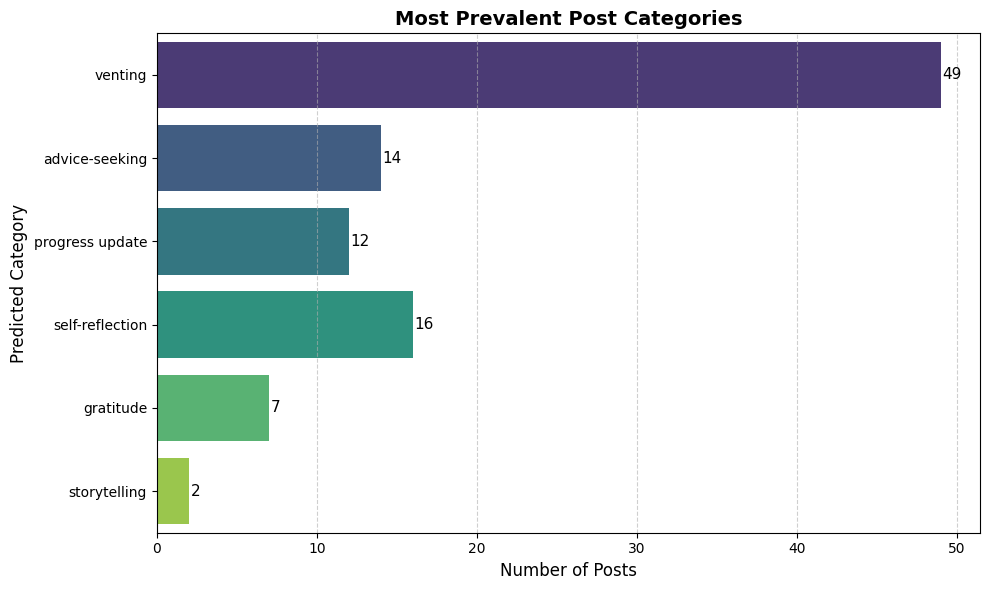

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the full list of categories to preserve missing ones
all_categories = ["venting", "advice-seeking", "progress update", "self-reflection", "gratitude", "storytelling"]

# Count occurrences
category_counts = categorized_df["predicted_label"].value_counts().reindex(all_categories, fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    y=category_counts.index,
    x=category_counts.values,
    palette="viridis"
)

# Annotate each bar with the count
for i, count in enumerate(category_counts.values):
    plt.text(count + 0.1, i, str(count), va="center", fontsize=11)

# Styling
plt.title("Most Prevalent Post Categories", fontsize=14, weight='bold')
plt.xlabel("Number of Posts", fontsize=12)
plt.ylabel("Predicted Category", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Which linguistic or emotional features are most strongly correlated with high-support
responses?

In [10]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Load emotion classifier
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True,
    truncation=True  # <--- this helps prevent token overflow
)
# Sample more posts (e.g., 100) and apply emotion detection
emotion_texts = df_merged["text"].dropna().str[:400].sample(100, random_state=42).tolist()
emotion_outputs = [emotion_classifier(text) for text in emotion_texts]

# Extract dominant emotion
dominant_emotions = [
    sorted(scores[0], key=lambda x: x["score"], reverse=True)[0]["label"]
    for scores in emotion_outputs
]

# Assign back to DataFrame
emotion_sample_df = pd.DataFrame({
    "text": emotion_texts,
    "dominant_emotion": dominant_emotions
})

# Merge this emotion data into the original df_merged
df_emotion_map = df_merged.copy()
df_emotion_map = df_emotion_map.iloc[emotion_sample_df.index]
df_emotion_map["dominant_emotion"] = emotion_sample_df["dominant_emotion"].values

emotion_support_stats = (
    df_emotion_map.groupby("dominant_emotion")[["score", "num_comments"]]
    .mean()
    .sort_values(by="score", ascending=False)
)

emotion_support_stats


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


,score,num_comments
dominant_emotion,,
disgust,1186.500000,87.166667
joy,1170.000000,111.875000
sadness,1085.888889,108.037037
fear,1083.840000,85.080000
anger,1020.400000,91.600000
neutral,994.695652,91.739130
surprise,753.000000,40.000000


In [11]:
from transformers import pipeline

# Truncate input text to max length accepted by model (typically 512 tokens ≈ 300-400 words)
def safe_truncate(text, max_chars=400):
    return text[:max_chars]

# Sample and clean text
emotion_sample_texts = df_merged["text"].dropna().sample(500, random_state=24).apply(safe_truncate).tolist()

# Get emotion predictions
emotion_results = [emotion_classifier(text) for text in emotion_sample_texts]

# Summarize top emotions
emotion_summary = []
for text, scores in zip(emotion_sample_texts, emotion_results):
    top_emotion = sorted(scores[0], key=lambda x: x["score"], reverse=True)[0]
    emotion_summary.append({
        "text": text[:150] + "...",
        "predicted_emotion": top_emotion["label"],
        "confidence": round(top_emotion["score"], 3)
    })

import pandas as pd
emotion_df = pd.DataFrame(emotion_summary)
emotion_df

,text,predicted_emotion,confidence
0,Does anyone else with depression have impaired...,neutral,0.503
1,Found out my daughter is cutting herself I (32...,fear,0.746
2,I just asked to pet someone's dog! I know it s...,fear,0.940
3,[L] [M] [17] My father assaulted me and I cont...,fear,0.737
4,Depression has been hard on my teeth Most days...,fear,0.326
...,...,...,...
495,"[O][27] It’s been a hot minute Hey, there! How...",neutral,0.741
496,If you've declawed your cat or debarked your d...,anger,0.635
497,so much of my childhood was undiagnosed anxiet...,sadness,0.984
498,DAE just wanna go to a psych hospital and be d...,surprise,0.502


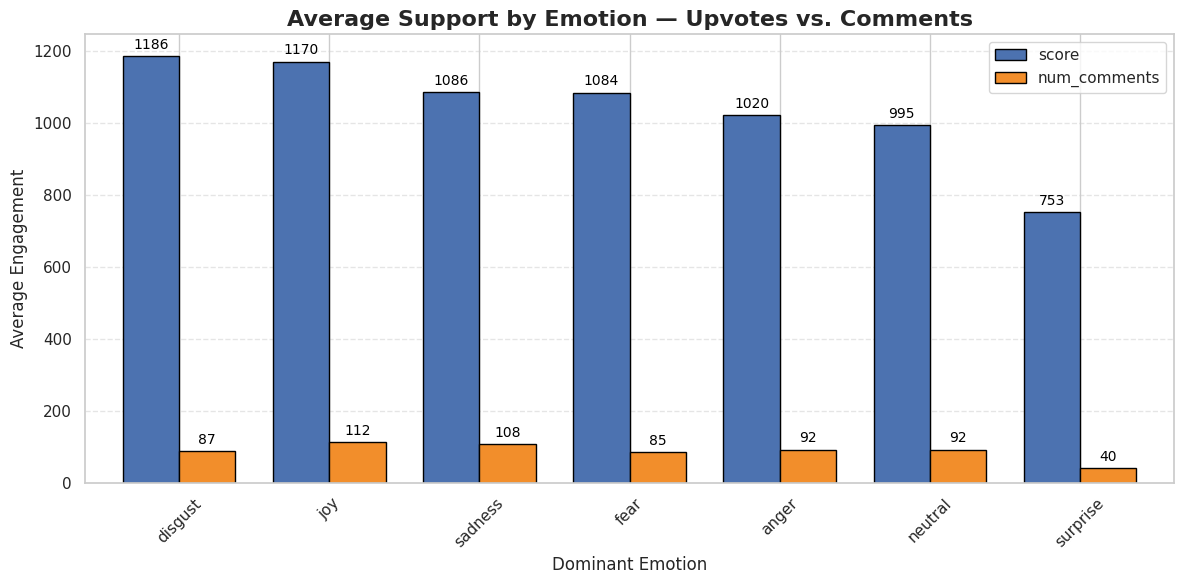

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a modern seaborn style
sns.set(style="whitegrid")

# Create the plot
ax = emotion_support_stats.plot(
    kind="bar",
    figsize=(12, 6),
    color=["#4c72b0", "#f28e2b"],  # custom palette
    width=0.75,
    edgecolor="black"
)

# Title & labels
plt.title("Average Support by Emotion — Upvotes vs. Comments", fontsize=16, weight="bold")
plt.ylabel("Average Engagement", fontsize=12)
plt.xlabel("Dominant Emotion", fontsize=12)

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.0f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                    textcoords='offset points')

# Grid & ticks
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()

How does the tone or stylistic presentation of a post influence the quantity and quality of
replies?

In [13]:
!pip install vaderSentiment

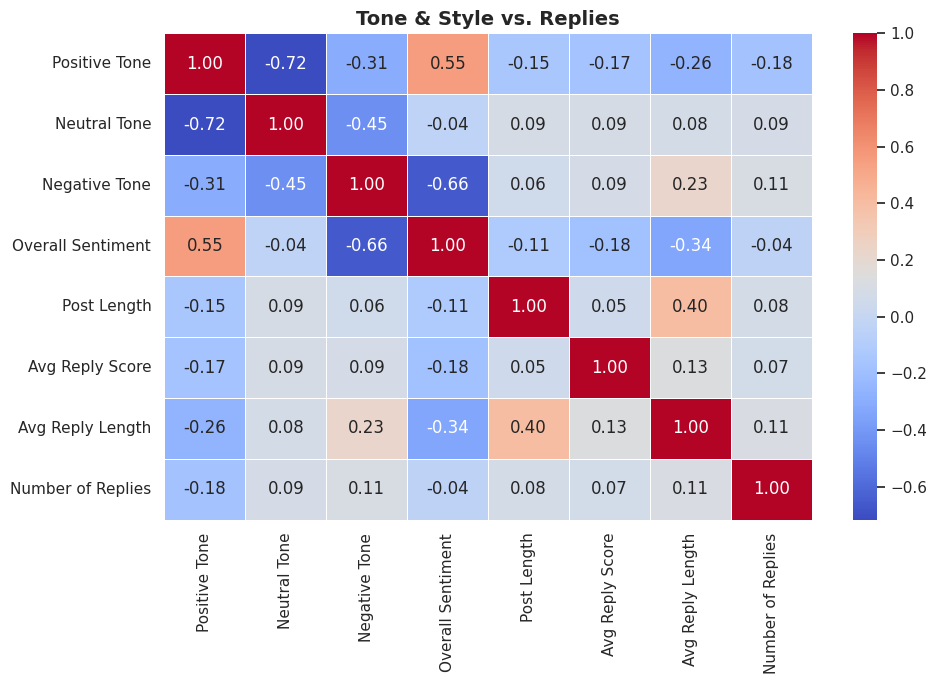

In [14]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
posts_df = pd.read_csv("/content/reddit_posts.csv")
comments_df = pd.read_csv("/content/reddit_post_comments.csv")

# Combine title and selftext
posts_df["text"] = posts_df["title"].fillna("") + " " + posts_df["selftext"].fillna("")
posts_df = posts_df[posts_df["text"].str.strip().astype(bool)].copy()

# Initialize VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER sentiment
def vader_sentiment_scores(text):
    scores = analyzer.polarity_scores(str(text))
    return pd.Series([scores["pos"], scores["neu"], scores["neg"], scores["compound"]])

posts_df[["vader_pos", "vader_neu", "vader_neg", "vader_compound"]] = posts_df["text"].apply(vader_sentiment_scores)

# Compute word count
posts_df["word_count"] = posts_df["text"].apply(lambda x: len(str(x).split()))

# Comment quality: score, length, count
comment_stats = comments_df.groupby("post_id").agg(
    avg_comment_score=("score", "mean"),
    avg_comment_length=("body", lambda x: np.mean([len(str(c).split()) for c in x])),
    comment_count=("body", "count")
).reset_index()

# Merge into full_df
full_df = posts_df.merge(comment_stats, left_on="id", right_on="post_id", how="left")
full_df = full_df.dropna(subset=["avg_comment_score", "avg_comment_length", "comment_count"])

# Correlation matrix
corr_matrix = full_df[[
    "vader_pos", "vader_neu", "vader_neg", "vader_compound",
    "word_count", "avg_comment_score", "avg_comment_length", "comment_count"
]].corr()

# Rename for clarity
renamer = {
    "vader_pos": "Positive Tone",
    "vader_neu": "Neutral Tone",
    "vader_neg": "Negative Tone",
    "vader_compound": "Overall Sentiment",
    "word_count": "Post Length",
    "avg_comment_score": "Avg Reply Score",
    "avg_comment_length": "Avg Reply Length",
    "comment_count": "Number of Replies"
}
corr_matrix.rename(columns=renamer, index=renamer, inplace=True)

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Tone & Style vs. Replies", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

# **Network Analysis**

Which users are most active or central in providing emotional support within the
community?

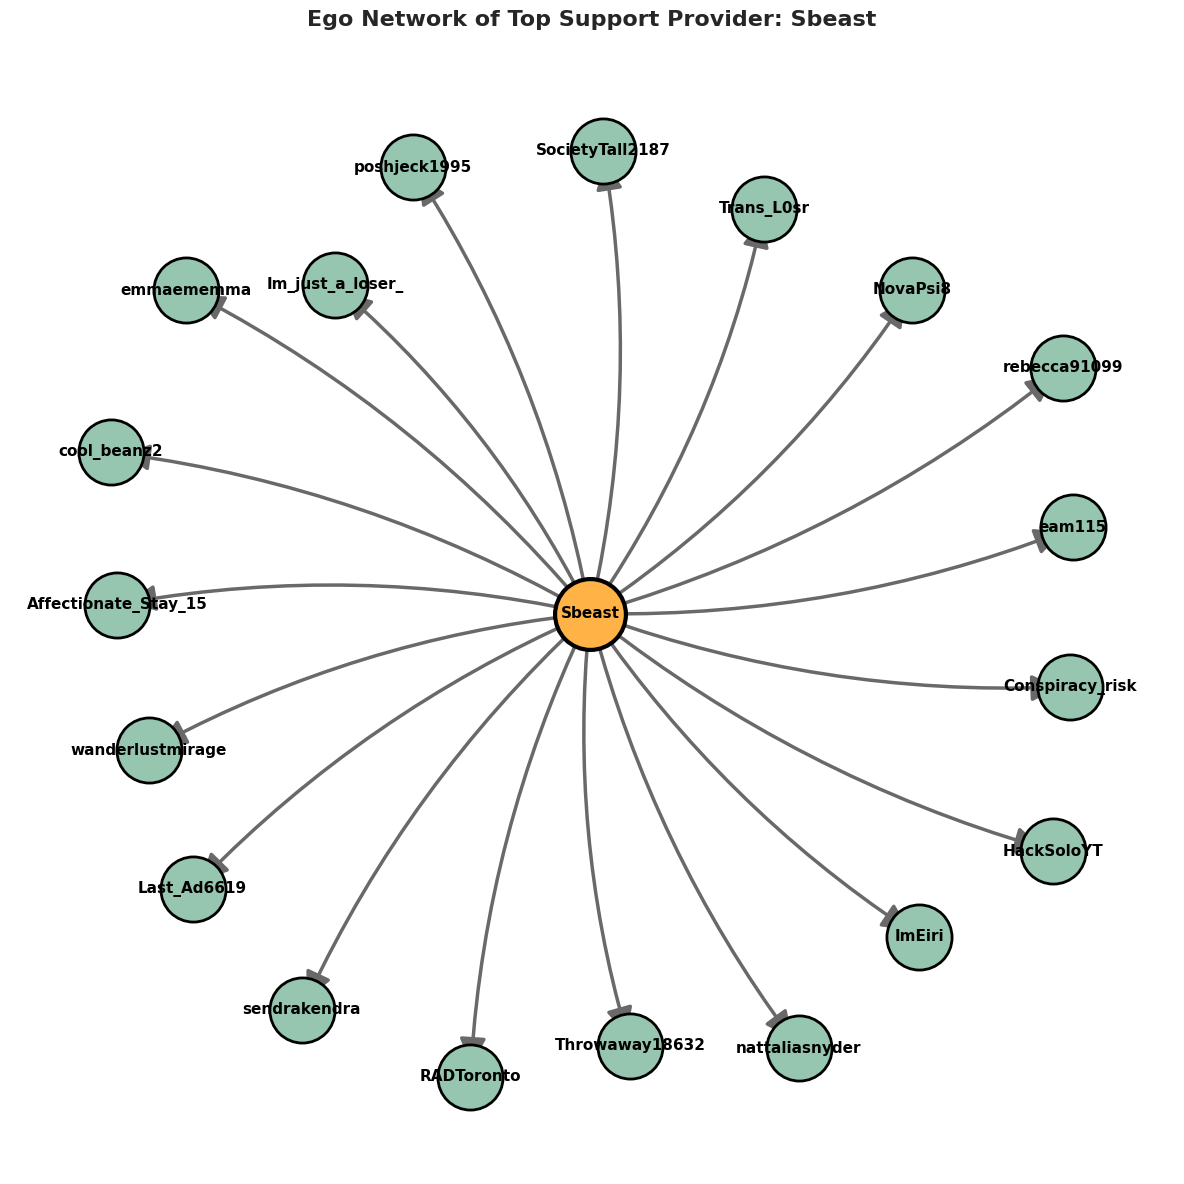

[('Sbeast', 0.003159820389156827),
 ('BRoccoli20', 0.0018293696989855313),
 ('drunky_crowette', 0.0016630633627141194),
 ('taostudent2019', 0.0013304506901712955),
 ('swild89', 0.0011641443538998836),
 ('Vulturette', 0.0011641443538998836),
 ('Fezzverbal', 0.0009978380176284716),
 ('TheAdlerian', 0.0009978380176284716),
 ('LucyLoo152', 0.0009978380176284716),
 ('FiguringItOut--', 0.0009978380176284716)]

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd

# Load your Reddit data files
posts_df = pd.read_csv("/content/reddit_posts.csv")
comments_df = pd.read_csv("/content/reddit_post_comments.csv")


# Step 1: Build the full graph from valid user interactions
valid_comments = comments_df[
    (comments_df["author"] != "[deleted]") & (comments_df["author"].notna())
]
valid_posts = posts_df[["id", "author"]].rename(columns={"id": "post_id", "author": "post_author"})
reply_data = valid_comments.merge(valid_posts, on="post_id")
reply_data = reply_data[reply_data["post_author"].notna()]  # remove rows with missing post authors

G = nx.DiGraph()
G.add_weighted_edges_from([(row["author"], row["post_author"], 1) for _, row in reply_data.iterrows()])

# Step 2: Filter out bots from the graph
bot_keywords = ["bot", "moderator", "auto", "helper", "mod"]
human_nodes = [
    node for node in G.nodes
    if all(bk.lower() not in str(node).lower() for bk in bot_keywords)
]
G_human = G.subgraph(human_nodes).copy()

# Step 3: Recalculate out-degree centrality for human users
out_deg_human = nx.out_degree_centrality(G_human)
top_helpers_human = sorted(out_deg_human.items(), key=lambda x: x[1], reverse=True)[:10]

# Step 4: Create ego graph for top support provider
top_supporter = top_helpers_human[0][0]
ego = nx.ego_graph(G_human, top_supporter, radius=1)
pos = nx.spring_layout(ego, seed=42)

# Step 5: Draw styled ego graph
plt.figure(figsize=(12, 12))

# Draw peripheral nodes
nx.draw_networkx_nodes(
    ego, pos,
    nodelist=[n for n in ego.nodes if n != top_supporter],
    node_size=2200,
    node_color="#96c5b0",  # soft teal
    edgecolors="black",
    linewidths=2
)

# Highlight central node
nx.draw_networkx_nodes(
    ego, pos,
    nodelist=[top_supporter],
    node_color="#ffb347",  # golden orange
    node_size=2600,
    edgecolors="black",
    linewidths=3
)

# Draw labels
nx.draw_networkx_labels(
    ego, pos,
    font_size=11,
    font_weight="bold",
    font_color="black"
)

# Draw arrows with clarity
nx.draw_networkx_edges(
    ego, pos,
    edge_color='dimgray',
    arrows=True,
    arrowstyle='-|>',
    arrowsize=40,
    width=2.5,
    connectionstyle="arc3,rad=0.1"
)

plt.title(f"Ego Network of Top Support Provider: {top_supporter}", fontsize=16, fontweight="bold", pad=20)
plt.axis("off")
plt.tight_layout()
plt.show()

top_helpers_human

Is emotional support primarily offered by a few highly active users, or is it distributed
more evenly?

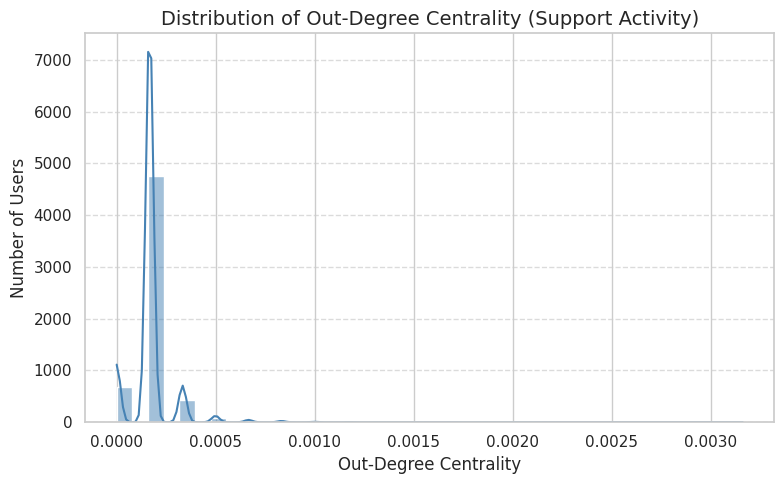

np.float64(0.2225934537357631)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get out-degree values
out_deg_values = np.array(list(out_deg_human.values()))

# Step 2: Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(out_deg_values, bins=40, kde=True, color="steelblue")
plt.title("Distribution of Out-Degree Centrality (Support Activity)", fontsize=14)
plt.xlabel("Out-Degree Centrality")
plt.ylabel("Number of Users")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Step 3: Calculate Gini coefficient
def gini(array):
    array = np.sort(array)
    n = len(array)
    cumvals = np.cumsum(array)
    return (n + 1 - 2 * np.sum(cumvals) / cumvals[-1]) / n

gini_value = gini(out_deg_values)
gini_value

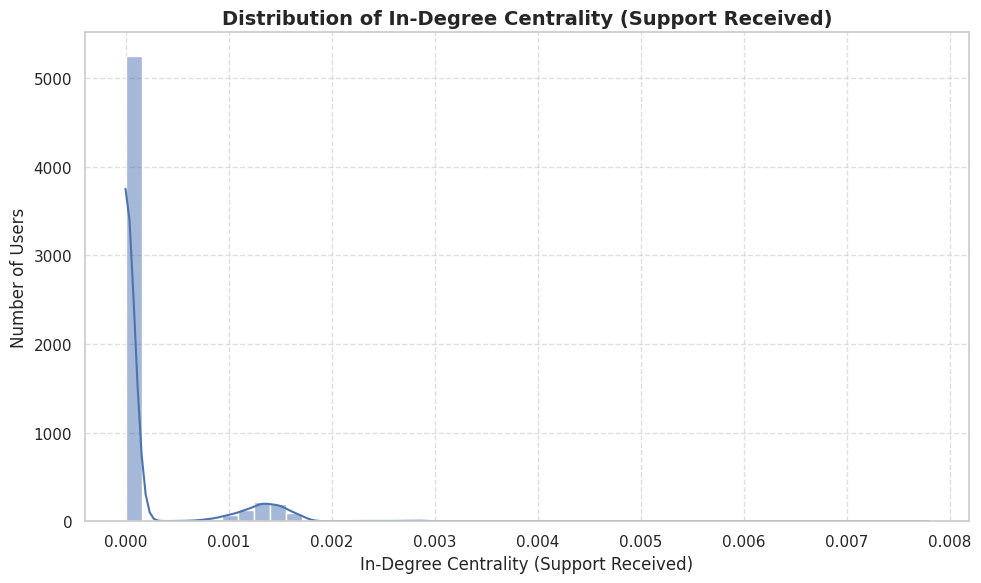

np.float64(0.8878054049167733)

In [17]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Rebuild the directed graph if not already available
G = nx.DiGraph()
for _, row in reply_data.iterrows():
    G.add_edge(row["author"], row["post_author"], weight=1)

# Calculate in-degree centrality
in_deg_centrality = nx.in_degree_centrality(G)

# Create a DataFrame for visualization
in_deg_df = pd.DataFrame(list(in_deg_centrality.items()), columns=["user", "in_deg_centrality"])

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(in_deg_df["in_deg_centrality"], bins=50, kde=True)
plt.title("Distribution of In-Degree Centrality (Support Received)", fontsize=14, weight="bold")
plt.xlabel("In-Degree Centrality (Support Received)")
plt.ylabel("Number of Users")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Calculate Gini coefficient to quantify inequality
def gini(array):
    sorted_arr = np.sort(array)
    n = len(array)
    cumulative = np.cumsum(sorted_arr)
    return (n + 1 - 2 * np.sum(cumulative) / cumulative[-1]) / n

gini_in_deg = gini(np.array(in_deg_df["in_deg_centrality"]))
gini_in_deg


In [18]:
import networkx as nx
import pandas as pd

# Rebuild the directed graph (if not already done)
G = nx.DiGraph()
for _, row in reply_data.iterrows():
    G.add_edge(row["author"], row["post_author"], weight=1)

# Recompute in-degree centrality
in_deg_centrality = nx.in_degree_centrality(G)
in_deg_df = pd.DataFrame(list(in_deg_centrality.items()), columns=["user", "in_deg_centrality"])
# Sort users by in-degree centrality to identify top support receivers
top_supported_users = in_deg_df.sort_values(by="in_deg_centrality", ascending=False).head(15)

# Format the centrality values for readability
top_supported_users["in_deg_centrality"] = (top_supported_users["in_deg_centrality"] * 100).round(3)

# Display the top supported users
print(top_supported_users)

                      user  in_deg_centrality
145               MrReeRee              0.779
718       FelicityOfficial              0.696
2450           tharsika123              0.630
2495  milksteakenthusiast1              0.398
1230      Capybaraontherun              0.332
1444             ArtsyCats              0.298
1590             worstgurl              0.282
3458   GrotiusandPufendorf              0.282
1561         qazsedcft0310              0.282
540      Ieatoutjelloshots              0.282
2052           trash666_69              0.282
1258           snowrachell              0.282
821           rebecca91099              0.282
779          FoxOfficial__              0.282
2517        Amyshesgotthis              0.265
